In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from math import exp
from torch.autograd import Variable

In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn as nn

In [ ]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2
    print(mu1, mu2, mu1_mu2, sigma1_sq, sigma2_sq, sigma12)
    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, predict, targets):
        assert predict.shape == targets.shape, 'predict & target shape do not match {} and {}'.format(predict.shape, targets.shape)
        total_loss = 0
        predict = predict.view(-1)
        targets = targets.view(-1)
#         predict = predict>0.5
        intersection = (predict * targets).sum()                            
        dice_loss = 1 - (abs(2.*intersection) + 1e-12)/(abs(predict.sum()) + abs(targets.sum()) + 1e-12)

        return dice_loss

In [ ]:
dice_loss = DiceLoss()

In [ ]:
ssim_score = SSIM()

In [ ]:
!wget www.cs.toronto.edu/~vmnih/data/mass_roads/train/map/10078660_15.tif
!wget www.cs.toronto.edu/~vmnih/data/mass_roads/train/map/10078675_15.tif
!ls

In [ ]:
image1 = np.array(Image.open("10078660_15.tif"))
flabel = np.zeros(image1.shape, dtype='uint8')

In [ ]:
totensor = T.ToTensor()

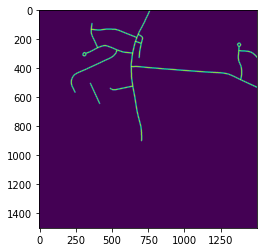

In [ ]:
plt.figure()
plt.imshow(image1)
plt.show()

In [ ]:
image1_t = totensor(image1)
flabel_t = totensor(flabel)

In [ ]:
image1_t = image1_t.unsqueeze(0)
flabel_t = flabel_t.unsqueeze(0)

In [ ]:
flabel_t

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [ ]:
print(dice_loss(image1_t, flabel_t))

tensor(1.)


In [ ]:
print(ssim_score(image1_t, image1_t))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]) tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]) tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]) tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-51wiop4a
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-51wiop4a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp37-cp37m-linux_x86_64.whl size=2773999 sha256=2eb31bb90a7d9bad25c0400f2977713a898de5cdf8451a114fd05bd636b244e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-yzg3z6rp/wheels/c1/7e/80/99adc0b2f215180486e24dd9c700028343ba5f566514a0ef05
Successfully built pydensecrf


In [ ]:
!pip install cython

In [4]:
import os
import pickle

In [5]:
fpath = '/content/drive/MyDrive/BTP'

In [55]:
with open(os.path.join(fpath, 'data_3.pb'), 'rb') as f:
    rdict = pickle.load(f)

In [ ]:
image_u = rdict['image'][0].transpose(1, 2, 0)
gt = rdict['gt'][0]
heat = rdict['heatmap'][0]
pred = rdict['pred'][0]

In [ ]:
image_u.shape, gt.shape, heat.shape, pred.shape

((1500, 3, 1500), (1500, 1500, 3), (1536, 1536), (1500, 1500, 3))

In [6]:
def normalise(image):
    res = np.zeros(image.shape)
    H, W, C = image.shape
    for c in range(C):
        maxi = np.max(image[:, :, c])
        mini = np.min(image[:, :, c])
        res[:, :, c] = (image[:, :, c]-mini)/(maxi-mini)
    return res

In [ ]:
image = normalise(image_u)

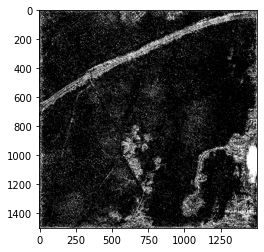

In [ ]:
plt.figure()
plt.imshow(pred[:, :, 0], cmap='gray')
plt.show()

In [ ]:
image[18:-18, 18:-18, :].shape, pred.shape

((1500, 1500, 3), (1500, 1500, 3))

In [7]:
import cv2 as cv

In [8]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import create_pairwise_bilateral, unary_from_labels, unary_from_softmax

In [ ]:
def getCRF(image, Lc, theta, n_iter, label_lines, compat_spat=12, compat_col=40, scale=5, prob=0.5):

#        n_iters: number of iterations of MAP inference.
#        sxy_gaussian: standard deviations for the location component
#            of the colour-independent term.
#        compat_gaussian: label compatibilities for the colour-independent
#            term (can be a number, a 1D array, or a 2D array).
#        kernel_gaussian: kernel precision matrix for the colour-independent
#            term (can take values CONST_KERNEL, DIAG_KERNEL, or FULL_KERNEL).
#        normalisation_gaussian: normalisation for the colour-independent term
#            (possible values are NO_NORMALIZATION, NORMALIZE_BEFORE, NORMALIZE_AFTER, NORMALIZE_SYMMETRIC).
#        sxy_bilateral: standard deviations for the location component of the colour-dependent term.
#        compat_bilateral: label compatibilities for the colour-dependent
#            term (can be a number, a 1D array, or a 2D array).
#        srgb_bilateral: standard deviations for the colour component
#            of the colour-dependent term.
#        kernel_bilateral: kernel precision matrix for the colour-dependent term
#            (can take values CONST_KERNEL, DIAG_KERNEL, or FULL_KERNEL).
#        normalisation_bilateral: normalisation for the colour-dependent term
#            (possible values are NO_NORMALIZATION, NORMALIZE_BEFORE, NORMALIZE_AFTER, NORMALIZE_SYMMETRIC).

      H = image.shape[0]
      W = image.shape[1]

      d = dcrf.DenseCRF2D(H, W, len(label_lines)+1)
      U = unary_from_labels(Lc.astype('int'), len(label_lines)+1, gt_prob= prob)

      d.setUnaryEnergy(U)

      del U

      # This potential penalizes small pieces of segmentation that are
      # spatially isolated -- enforces more spatially consistent segmentations
      # This adds the color-independent term, features are the locations only.
      # sxy = The scaling factors per dimension.
      d.addPairwiseGaussian(sxy=(theta,theta), compat=compat_spat, kernel=dcrf.DIAG_KERNEL, #compat=6
                      normalization=dcrf.NORMALIZE_SYMMETRIC)

      # sdims = The scaling factors per dimension.
      # schan = The scaling factors per channel in the image.
      # This creates the color-dependent features and then add them to the CRF
      feats = create_pairwise_bilateral(sdims=(theta, theta), schan=(scale, scale, scale), #11,11,11
                                  img=image, chdim=2)

      del image

      d.addPairwiseEnergy(feats, compat=compat_col, #20
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)
      del feats

      Q = d.inference(n_iter)

      #preds = np.array(Q, dtype=np.float32).reshape(
      #  (len(label_lines)+1, nx, ny)).transpose(1, 2, 0)
      #preds = np.expand_dims(preds, 0)
      #preds = np.squeeze(preds)

      return np.argmax(Q, axis=0).reshape((H, W)) #, preds#, p, R, d.klDivergence(Q),


In [29]:
def getCRFMap(heat, image, compat_spat=3, iters=20, thetaGam=3, compat_col=2, thetaAlpha=3, thetaBeta=1):
    
    bg = 1 - np.copy(heat)
    full = np.array([bg, heat])
    H, W , C = image.shape
    NLABELS = 2
    U = unary_from_softmax(full)  # note: num classes is first dim
    d = dcrf.DenseCRF2D(W, H, NLABELS)
    d.setUnaryEnergy(U)

    del U
    d.addPairwiseGaussian(sxy=thetaGam, compat=compat_spat, kernel=dcrf.DIAG_KERNEL, #compat=6
                        normalization=dcrf.NORMALIZE_SYMMETRIC)
    # feats = create_pairwise_bilateral(sdims=(theta, theta), schan=(scale, scale, scale), #11,11,11
    #                                 img=image, chdim=2)
    # d.addPairwiseEnergy(feats, compat=compat_col, #20
    #                     kernel=dcrf.DIAG_KERNEL,
    #                     normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseBilateral(sxy=thetaAlpha, srgb=thetaBeta, rgbim=image.astype('uint8'), compat=compat_col, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    Q_unary = d.inference(iters)

    map_soln_unary = np.argmax(Q_unary, axis=0)

    crfres = map_soln_unary.reshape((H,W))
    return crfres

In [44]:
def crf(original_image, mask_img, weight_spat=3, thetaGam=3, gt_prob=0.7, iters=10):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=gt_prob, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(thetaGam, thetaGam), compat=weight_spat, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(iters)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [10]:
with open(os.path.join(fpath, 'data_0.pb'), 'rb') as f:
    rdict = pickle.load(f)

In [64]:
from scipy.spatial.distance import jaccard
from skimage.color import gray2rgb
from skimage.color import rgb2gray

In [59]:
def iou(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    return(1 - jaccard(y_true, y_pred))

IoU before :0.2780807732136693
IoU after :0.0


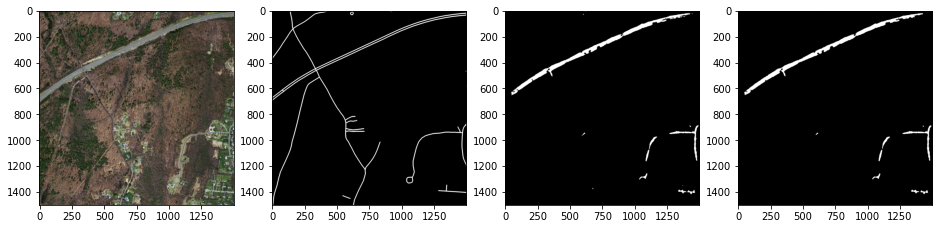

IoU before :0.20730381685161725
IoU after :0.0


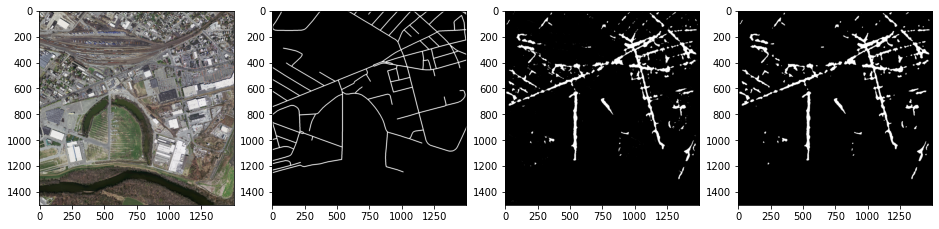

IoU before :0.24273965437073775
IoU after :0.0


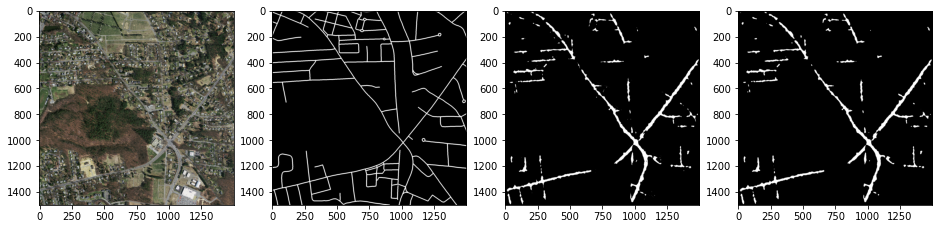

In [73]:
for i in range(3):
    image_u = rdict['image'][i]
    gt = rdict['gt'][i]
    heat = rdict['heatmap'][i]
    pred = rdict['pred'][i]
    image = normalise(image_u)
    gray = 0.2989*pred[:, :, 0] + 0.5870*pred[:, :, 1] + 0.1140*pred[:, :, 2]
    # print(image.shape, gt.shape, heat.shape, pred.shape)
    # crfres = getCRFMap(gray, image, compat_spat=2, iters=20, thetaGam=1)
    print("IoU before :{}".format(iou(gt, pred)))
    crfres = crf(image, pred, weight_spat=3, thetaGam=2, gt_prob=0.7, iters=10)
    print("IoU after :{}".format(iou(rgb2gray(gt), crfres)))
    plt.figure(figsize=(16, 12))
    plt.subplot(141)
    plt.imshow(image)
    plt.subplot(142)
    plt.imshow(gt)
    plt.subplot(143)
    plt.imshow(pred)
    plt.subplot(144)
    plt.imshow(crfres, cmap='gray')
    plt.show()


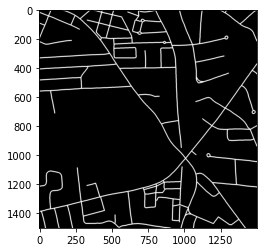

In [70]:
plt.figure()
plt.imshow(gt[:, :, 0], cmap='gray')
plt.show()

In [ ]:
print(image.shape, full.transpose(1, 2, 0).shape)

(1536, 1536, 3) (1536, 1536, 2)
